# Synthetic Data from 3-Dimensional Lorentz System

In [73]:
import numpy as np
from scipy.integrate import odeint
import quantities as pq
import neo
from elephant.spike_train_generation import inhomogeneous_poisson_process


def integrated_oscillator(dt, num_steps, x0=0, y0=1, angular_frequency=2*np.pi*1e-3):
    """
    Parameters
    ----------
    dt : float
        Integration time step in ms.
    num_steps : int
        Number of integration steps -> max_time = dt*(num_steps-1).
    x0, y0 : float
        Initial values in three dimensional space.
    angular_frequency : float
        Angular frequency in 1/ms.

    Returns
    -------
    t : (num_steps) np.ndarray
        Array of timepoints
    (2, num_steps) np.ndarray
        Integrated two-dimensional trajectory (x, y, z) of the harmonic oscillator
    """

    assert isinstance(num_steps, int), "num_steps has to be integer"
    t = dt*np.arange(num_steps)
    x = x0*np.cos(angular_frequency*t) + y0*np.sin(angular_frequency*t)
    y = -x0*np.sin(angular_frequency*t) + y0*np.cos(angular_frequency*t)
    return t, np.array((x, y))


def integrated_lorenz(dt, num_steps, x0=0, y0=1, z0=1.05,
                      sigma=10, rho=28, beta=2.667, tau=1e3):
    """

    Parameters
    ----------
    dt :
        Integration time step in ms.
    num_steps : int
        Number of integration steps -> max_time = dt*(num_steps-1).
    x0, y0, z0 : float
        Initial values in three dimensional space
    sigma, rho, beta : float
        Parameters defining the lorenz attractor
    tau : characteristic timescale in ms

    Returns
    -------
    t : (num_steps) np.ndarray
        Array of timepoints
    (3, num_steps) np.ndarray
        Integrated three-dimensional trajectory (x, y, z) of the Lorenz attractor
    """
    def _lorenz_ode(point_of_interest, timepoint, sigma, rho, beta, tau):
        """
        Fit the model with `spiketrains` data and apply the dimensionality
        reduction on `spiketrains`.

        Parameters
        ----------
        point_of_interest : tuple
            Tupel containing coordinates (x,y,z) in three dimensional space.
        timepoint : a point of interest in time
        dt :
            Integration time step in ms.
        num_steps : int
            Number of integration steps -> max_time = dt*(num_steps-1).
        sigma, rho, beta : float
            Parameters defining the lorenz attractor
        tau : characteristic timescale in ms

        Returns
        -------
        x_dot, y_dot, z_dot : float
            Values of the lorenz attractor's partial derivatives
            at the point x, y, z.
        """

        x, y, z = point_of_interest

        x_dot = (sigma*(y - x)) / tau
        y_dot = (rho*x - y - x*z) / tau
        z_dot = (x*y - beta*z) / tau
        return x_dot, y_dot, z_dot

    assert isinstance(num_steps, int), "num_steps has to be integer"

    t = dt*np.arange(num_steps)
    poi = (x0, y0, z0)
    return t, odeint(_lorenz_ode, poi, t, args=(sigma, rho, beta, tau)).T


def random_projection(data, embedding_dimension, loc=0, scale=None):
    """
    Parameters
    ----------
    data : np.ndarray
        Data to embed, shape=(M, N)
    embedding_dimension : int
        Embedding dimension, dimensionality of the space to project to.
    loc : float or array_like of floats
        Mean (“centre”) of the distribution.
    scale : float or array_like of floats
        Standard deviation (spread or “width”) of the distribution.

    Returns
    -------
    np.ndarray
       Random (normal) projection of input data, shape=(dim, N)

    See Also
    --------
    np.random.normal()

    """
    if scale is None:
        scale = 1 / np.sqrt(data.shape[0])
    projection_matrix = np.random.normal(loc, scale, (embedding_dimension, data.shape[0]))
    return np.dot(projection_matrix, data)


def generate_spiketrains(instantaneous_rates, num_trials, timestep):
    """
    Parameters
    ----------
    instantaneous_rates : np.ndarray
        Array containing time series.
    timestep :
        Sample period.
    num_steps : int
        Number of timesteps -> max_time = timestep*(num_steps-1).

    Returns
    -------
    spiketrains : list of neo.SpikeTrains
        List containing spiketrains of inhomogeneous Poisson
        processes based on given instantaneous rates.

    """

    spiketrains = []
    for _ in range(num_trials):
        spiketrains_per_trial = []
        for inst_rate in instantaneous_rates:
            anasig_inst_rate = neo.AnalogSignal(inst_rate, sampling_rate=1/timestep, units=pq.Hz)
            spiketrains_per_trial.append(inhomogeneous_poisson_process(anasig_inst_rate))
        spiketrains.append(spiketrains_per_trial)

    return spiketrains

In [74]:
# set parameters for the integration of the Lorentz attractor
timestep = 1 * pq.ms
transient_duration = 10 * pq.s
trial_duration = 30 * pq.s
num_steps_transient = int((transient_duration.rescale('ms')/timestep).magnitude)
num_steps = int((trial_duration.rescale('ms')/timestep).magnitude)

# set parameters for spike train generation
max_rate = 70 * pq.Hz
np.random.seed(42)  # for visualization purposes, we want to get identical spike trains at any run

# specify data
num_trials = 20
num_spiketrains = 50

# calculate the oscillator
times, lorentz_trajectory_3dim = integrated_lorenz(
    timestep, num_steps=num_steps_transient+num_steps, x0=0, y0=1, z0=1.25)
times = (times - transient_duration).rescale('s').magnitude
times_trial = times[num_steps_transient:]

# random projection
lorentz_trajectory_Ndim = random_projection(
    lorentz_trajectory_3dim[:, num_steps_transient:], embedding_dimension=num_spiketrains)

# calculate instantaneous rate
normed_traj = lorentz_trajectory_Ndim / lorentz_trajectory_Ndim.max()
instantaneous_rates_lorentz = np.power(max_rate.magnitude, normed_traj)

# generate spiketrains
spiketrains_lorentz = generate_spiketrains(
    instantaneous_rates_lorentz, num_trials, timestep)


In [88]:
# print(np.array(spiketrains_lorentz).shape)
# print(np.array(spiketrains_lorentz[1][1]).shape)
print(spiketrains_lorentz[0])
# for spiketrain in spiketrains_lorentz:
#     print(np.array(spiketrain).shape)

[<SpikeTrain(array([ 0.56618101,  0.9590733 ,  2.13036107,  2.1327595 ,  2.44325996,
        3.34213637,  4.95750069,  5.23572327,  5.45378297,  5.47931462,
        5.59831087,  5.75090837,  6.68859598,  7.39606967,  8.06609019,
        8.24739087,  9.12779163,  9.39696924, 11.73822979, 12.42640571,
       14.81219129, 14.902727  , 15.02895925, 15.62232888, 15.88176876,
       16.59595282, 16.90506876, 17.12418446, 17.3984992 , 18.59531643,
       20.02927757, 20.34396463, 20.45960607, 22.56969772, 22.93629844,
       24.92395391, 25.03102658, 25.40301861, 25.41252034, 25.7782447 ,
       26.10589802, 26.11577859, 26.68061077, 26.71588501, 27.62853362,
       27.64230832, 29.60704582, 29.79557735, 29.89681913]) * s, [0.0 s, 30.0 s])>, <SpikeTrain(array([ 4.50068132,  4.98385288,  6.35173935,  8.33105319, 10.46378323,
       11.79279896, 20.53681627, 21.06287173, 24.47546942, 25.79966378,
       26.1641255 , 27.06375729, 27.43713815, 28.22349974]) * s, [0.0 s, 30.0 s])>, <SpikeTrain(arr

In [138]:
print(spiketrains_lorentz[0][49].shape)

(31,)


In [85]:
a = np.array([ 0.56618101,  0.9590733 ,  2.13036107,  2.1327595 ,  2.44325996,
        3.34213637,  4.95750069,  5.23572327,  5.45378297,  5.47931462,
        5.59831087,  5.75090837,  6.68859598,  7.39606967,  8.06609019,
        8.24739087,  9.12779163,  9.39696924, 11.73822979, 12.42640571,
       14.81219129, 14.902727  , 15.02895925, 15.62232888, 15.88176876,
       16.59595282, 16.90506876, 17.12418446, 17.3984992 , 18.59531643,
       20.02927757, 20.34396463, 20.45960607, 22.56969772, 22.93629844,
       24.92395391, 25.03102658, 25.40301861, 25.41252034, 25.7782447 ,
       26.10589802, 26.11577859, 26.68061077, 26.71588501, 27.62853362,
       27.64230832, 29.60704582, 29.79557735, 29.89681913])
a.shape

(49,)

In [89]:
a = [<SpikeTrain(array([ 0.56618101,  0.9590733 ,  2.13036107,  2.1327595 ,  2.44325996,
        3.34213637,  4.95750069,  5.23572327,  5.45378297,  5.47931462,
        5.59831087,  5.75090837,  6.68859598,  7.39606967,  8.06609019,
        8.24739087,  9.12779163,  9.39696924, 11.73822979, 12.42640571,
       14.81219129, 14.902727  , 15.02895925, 15.62232888, 15.88176876,
       16.59595282, 16.90506876, 17.12418446, 17.3984992 , 18.59531643,
       20.02927757, 20.34396463, 20.45960607, 22.56969772, 22.93629844,
       24.92395391, 25.03102658, 25.40301861, 25.41252034, 25.7782447 ,
       26.10589802, 26.11577859, 26.68061077, 26.71588501, 27.62853362,
       27.64230832, 29.60704582, 29.79557735, 29.89681913]) * s, [0.0 s, 30.0 s])>]

SyntaxError: invalid syntax (<ipython-input-89-fdd9adf74c68>, line 1)

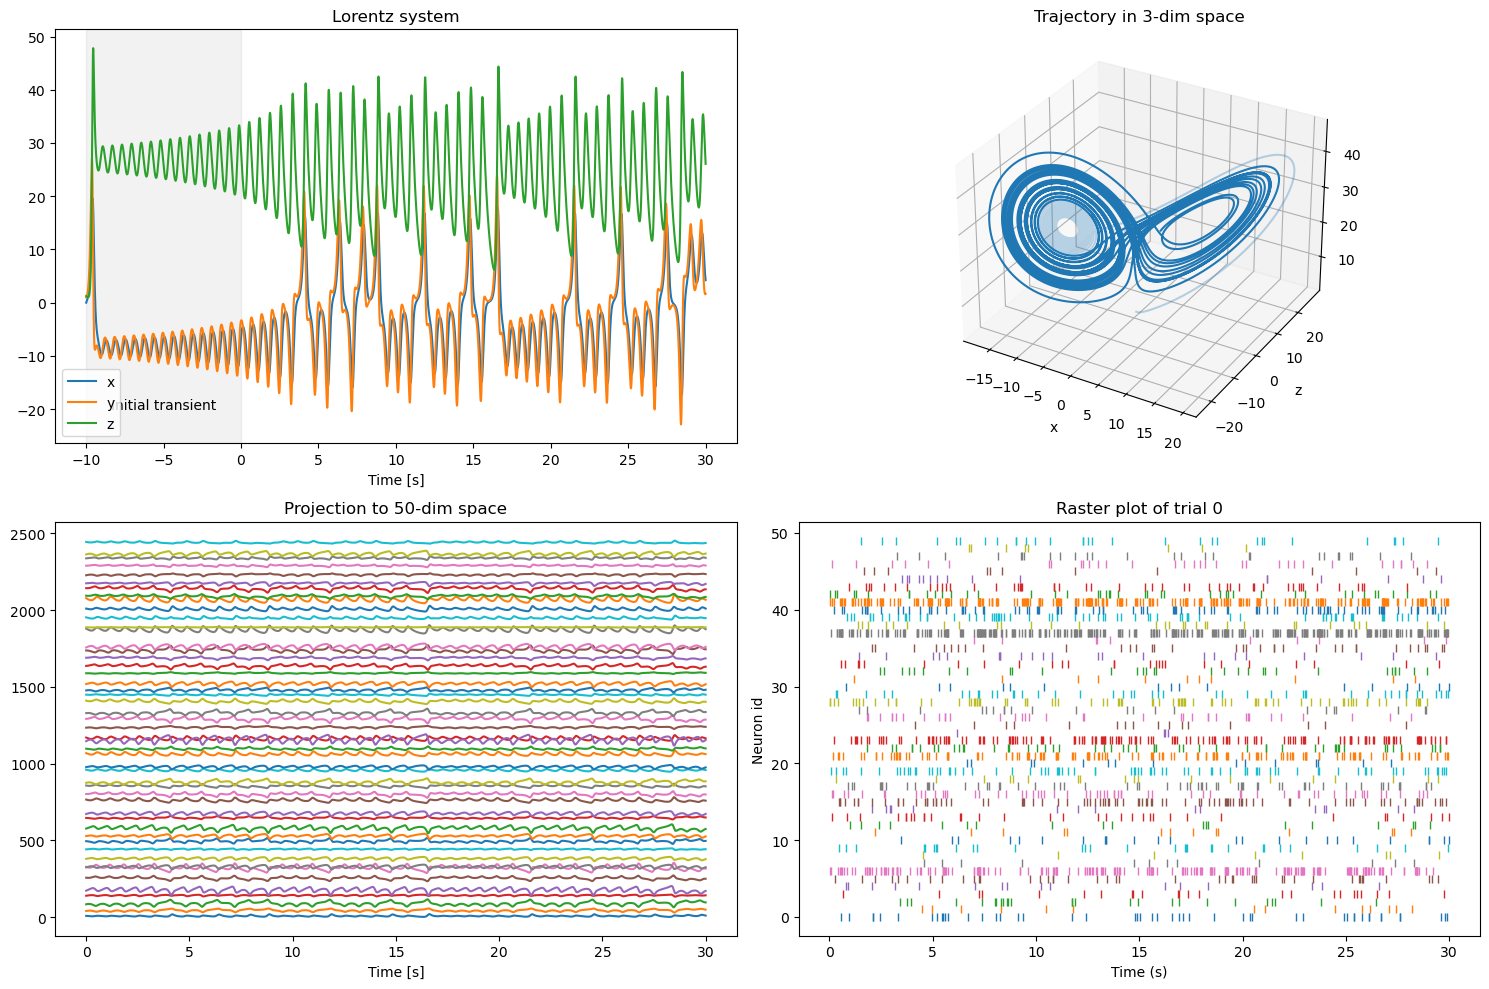

In [75]:
from mpl_toolkits.mplot3d import Axes3D


f = plt.figure(figsize=(15, 10))
ax1 = f.add_subplot(2, 2, 1)
ax2 = f.add_subplot(2, 2, 2, projection='3d')
ax3 = f.add_subplot(2, 2, 3)
ax4 = f.add_subplot(2, 2, 4)

ax1.set_title('Lorentz system')
ax1.set_xlabel('Time [s]')
labels = ['x', 'y', 'z']
for i, x in enumerate(lorentz_trajectory_3dim):
    ax1.plot(times, x, label=labels[i])
ax1.axvspan(-transient_duration.rescale('s').magnitude, 0, color='gray', alpha=0.1)
ax1.text(-5, -20, 'Initial transient', ha='center')
ax1.legend()

ax2.set_title(f'Trajectory in 3-dim space')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_ylabel('z')
ax2.plot(lorentz_trajectory_3dim[0, :num_steps_transient],
         lorentz_trajectory_3dim[1, :num_steps_transient],
         lorentz_trajectory_3dim[2, :num_steps_transient], c='C0', alpha=0.3)
ax2.plot(lorentz_trajectory_3dim[0, num_steps_transient:],
         lorentz_trajectory_3dim[1, num_steps_transient:],
         lorentz_trajectory_3dim[2, num_steps_transient:], c='C0')

ax3.set_title(f'Projection to {num_spiketrains}-dim space')
ax3.set_xlabel('Time [s]')
y_offset = lorentz_trajectory_Ndim.std() * 3
for i, y in enumerate(lorentz_trajectory_Ndim):
    ax3.plot(times_trial, y + i*y_offset)

trial_to_plot = 0
ax4.set_title(f'Raster plot of trial {trial_to_plot}')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Neuron id')
for i, spiketrain in enumerate(spiketrains_lorentz[trial_to_plot]):
    ax4.plot(spiketrain, np.ones(len(spiketrain)) * i, ls='', marker='|')

plt.tight_layout()
plt.show()

In [120]:
# specify fitting parameters
bin_size = 20 * pq.ms
latent_dimensionality = 3

gpfa_3dim = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)
trajectories = gpfa_3dim.fit_transform(spiketrains_lorentz)

Initializing parameters using factor analysis...

Fitting GPFA model...


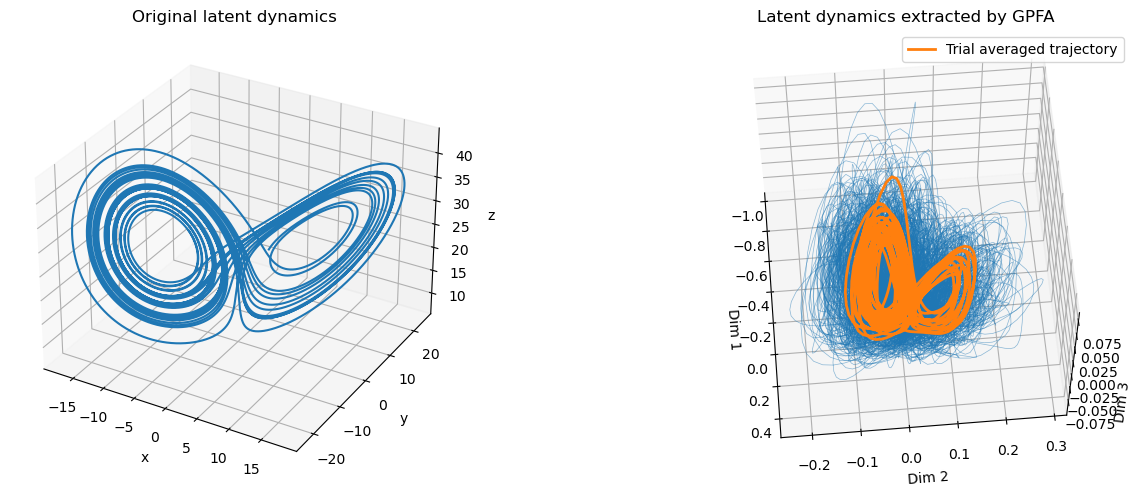

In [121]:
f = plt.figure(figsize=(15, 5))
ax1 = f.add_subplot(1, 2, 1, projection='3d')
ax2 = f.add_subplot(1, 2, 2, projection='3d')

linewidth_single_trial = 0.5
color_single_trial = 'C0'
alpha_single_trial = 0.5

linewidth_trial_average = 2
color_trial_average = 'C1'

ax1.set_title('Original latent dynamics')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.plot(lorentz_trajectory_3dim[0, num_steps_transient:],
         lorentz_trajectory_3dim[1, num_steps_transient:],
         lorentz_trajectory_3dim[2, num_steps_transient:])

ax2.set_title('Latent dynamics extracted by GPFA')
ax2.set_xlabel('Dim 1')
ax2.set_ylabel('Dim 2')
ax2.set_zlabel('Dim 3')
# single trial trajectories
for single_trial_trajectory in trajectories:
    ax2.plot(single_trial_trajectory[0], single_trial_trajectory[1], single_trial_trajectory[2],
             lw=linewidth_single_trial, c=color_single_trial, alpha=alpha_single_trial)
# trial averaged trajectory
average_trajectory = np.mean(trajectories, axis=0)
ax2.plot(average_trajectory[0], average_trajectory[1], average_trajectory[2], lw=linewidth_trial_average, c=color_trial_average, label='Trial averaged trajectory')
ax2.legend()
ax2.view_init(azim=-5, elev=60)  # an optimal viewing angle for the trajectory extracted from our fixed spike trains

plt.tight_layout()
plt.show()

# Monkey PFC Data

In [1]:
from pathlib import Path
import sys
import random
import matplotlib
import matplotlib.pyplot as plt
import pickle
from sklearn.decomposition import PCA
from scipy import signal
from scipy import stats
from sklearn.model_selection import train_test_split
from indl.fileio import from_neuropype_h5
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
from itertools import cycle

import os

if Path.cwd().stem == 'Analysis':
    os.chdir(Path.cwd().parent.parent)
    
    
data_path = Path.cwd() / 'StudyLocationRule'/ 'Data' / 'Preprocessed'
if not (data_path).is_dir():
    !kaggle datasets download --unzip --path {str(data_path)} cboulay/macaque-8a-spikes-rates-and-saccades
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")
    
from misc.misc import sess_infos, load_macaque_pfc, dec_from_enc

load_kwargs = {
    'valid_outcomes': (0,9),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': False,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, np.inf),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}

Data directory found. Skipping download.


In [2]:
test_sess_ix = 1
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
print(f"\nImporting session {sess_id}")
X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spiketrains', **load_kwargs)
print(X_rates.shape, Y.shape)


Importing session sra3_1_j_050_00+
(520, 36, 2718) (520, 1)


In [39]:
ax_info

{'instance_data':       Marker ExperimentType NewType CueColour TargetRule TargetStr  \
 75    Target              C     SR3         b         UU        UU   
 79    Target              C     SR3         b         UU        UU   
 80    Target              C     SR3         g         DD        DD   
 82    Target              C     SR3         g         DD        DD   
 86    Target              C     SR3         b         UU        UU   
 ...      ...            ...     ...       ...        ...       ...   
 1262  Target              C     SR3         b         DL        DL   
 1264  Target              C     SR3         r         UR        UR   
 1265  Target              C     SR3         r         UR        UR   
 1267  Target              C     SR3         b         DL        DL   
 1269  Target              C     SR3         b         DL        DL   
 
      DistractorStr  TargetValue  IsGood  EyelinkTime  ...  NEVTimestamps  \
 75              DD          NaN    True  2627.55826

In [127]:
times = np.array(ax_info['timestamps'])
print(min(times), max(times), times.shape)

-0.6 2.117 (2718,)


[-0.557, -0.495, -0.466, -0.276, -0.247, 0.088, 0.201, 0.202, 0.233, 0.303, 0.553, 0.5920000000000001, 0.673, 0.708, 0.722, 1.35, 1.351, 1.381, 1.3880000000000001, 1.433, 1.4929999999999999]


In [48]:
rates = X_rates[0].T
rates.shape

(2718, 36)

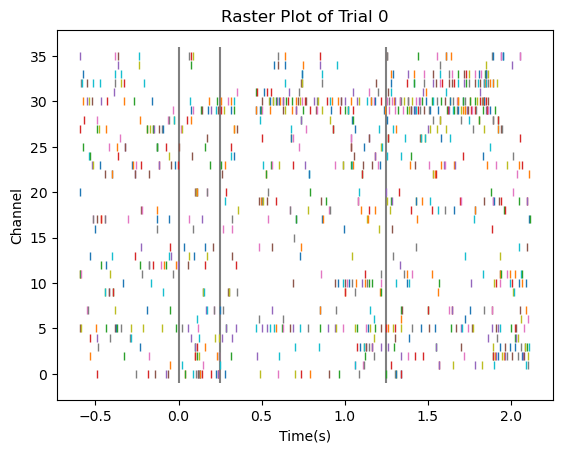

In [72]:
trial_to_plot = 0
rates = X_rates[trial_to_plot].T
for i in range(np.size(rates, 0)):
    for j in range(np.size(rates, 1)):
        if rates[i,j]:
            plt.plot(times[i], j, marker='|')
plt.vlines(0, -1, 36, colors='gray', linestyles='solid', label='Target Onset')
plt.vlines(0.25, -1, 36, colors='gray', linestyles='solid', label='Color Cue')
plt.vlines(1.25, -1, 36, colors='gray', linestyles='solid', label='Movement Onset')
plt.xlabel('Time(s)')
plt.ylabel('Channel')
plt.title(f'Raster Plot of Trial {trial_to_plot}')
# plt.legend(loc="lower right", bbox_to_anchor=(1,0))
plt.show()

ValueError: structure of the spiketrains is not correct: 0-axis should be trials, 1-axis neo.SpikeTrainand 2-axis spike times

In [114]:
from neo.core import SpikeTrain
from quantities import s
tmp = X_rates[0,0,:]
train = SpikeTrain([3, 4, 5]*s, t_stop=10.0)

In [147]:
spikes = []
for trial in range(np.size(X_rates,0)):
    per_trial = []
    for ch in range(np.size(X_rates,1)):
        per_channel = []
        for t in range(np.size(X_rates,2)):
            if X_rates[1,ch,t]:
                per_channel.append(times[t])
        train = SpikeTrain(per_channel*s, t_start = min(times), t_stop=max(times))
        per_trial.append(train)
    spikes.append(per_trial)
print(len(spikes), len(spikes[0]), len(spikes[0][0]))
print(spikes[0][0])

520 36 21
[-0.557 -0.495 -0.466 -0.276 -0.247  0.088  0.201  0.202  0.233  0.303
  0.553  0.592  0.673  0.708  0.722  1.35   1.351  1.381  1.388  1.433
  1.493] s


In [148]:
from elephant.gpfa import GPFA


# specify fitting parameters
bin_size = 20 * pq.ms
latent_dimensionality = 3

gpfa_3dim = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)
trajectories = gpfa_3dim.fit_transform(spikes)

Initializing parameters using factor analysis...

Fitting GPFA model...


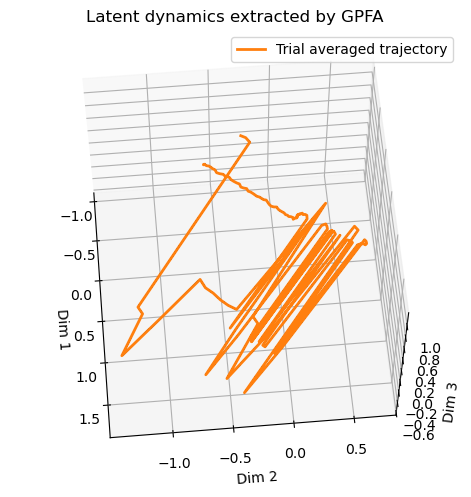

In [151]:
f = plt.figure(figsize=(15, 5))
ax1 = f.add_subplot(1, 2, 1, projection='3d')

linewidth_single_trial = 0.5
color_single_trial = 'C0'
alpha_single_trial = 0.5

linewidth_trial_average = 2
color_trial_average = 'C1'


ax1.set_title('Latent dynamics extracted by GPFA')
ax1.set_xlabel('Dim 1')
ax1.set_ylabel('Dim 2')
ax1.set_zlabel('Dim 3')
# single trial trajectories
for single_trial_trajectory in trajectories:
    ax1.plot(single_trial_trajectory[0], single_trial_trajectory[1], single_trial_trajectory[2],
             lw=linewidth_single_trial, c=color_single_trial, alpha=alpha_single_trial)
# trial averaged trajectory
average_trajectory = np.mean(trajectories, axis=0)
ax1.plot(average_trajectory[0], average_trajectory[1], average_trajectory[2], lw=linewidth_trial_average, c=color_trial_average, label='Trial averaged trajectory')
ax1.legend()
ax1.view_init(azim=-5, elev=60)  # an optimal viewing angle for the trajectory extracted from our fixed spike trains

plt.tight_layout()
plt.show()

In [155]:
# specify fitting parameters
bin_size = 20 * pq.ms
latent_dimensionality = 2

gpfa_2dim = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)
trajectories = gpfa_2dim.fit_transform(spikes)

Initializing parameters using factor analysis...

Fitting GPFA model...


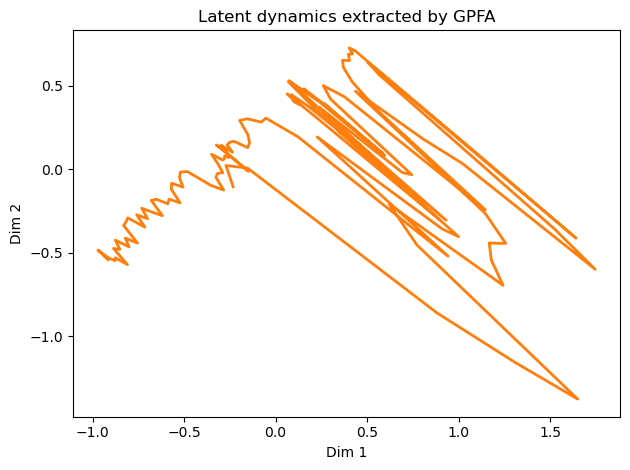

In [165]:
# f, (ax1, ax2) =  plt.subplots(1, 2, figsize=(15, 5))

linewidth_single_trial = 0.1
color_single_trial = 'C0'
alpha_single_trial = 0.5

linewidth_trial_average = 2
color_trial_average = 'C1'


plt.title('Latent dynamics extracted by GPFA')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
# plt.set_aspect(1)
# single trial trajectories
for single_trial_trajectory in trajectories:
    plt.plot(single_trial_trajectory[0], single_trial_trajectory[1], '-', lw=linewidth_single_trial, c=color_single_trial, alpha=alpha_single_trial)
# trial averaged trajectory
average_trajectory = np.mean(trajectories, axis=0)
plt.plot(average_trajectory[0], average_trajectory[1], '-', lw=linewidth_trial_average, c=color_trial_average, label='Trial averaged trajectory')
# plt.legend()

plt.tight_layout()
plt.show()